# Mind the Gap
## Inequality and Diversification

## Asset Exchange Models

See for example: Jie Li, Bruce M. Boghosian, Chengli Li, “The Affine Wealth Model: An agent-based model of asset exchange that allows for negative-wealth agents and its empirical validation”, arXiv.org, (2016). https://arxiv.org/pdf/1604.02370.pdf

In [1]:
using StatsBase, Printf, Plots, Random, Distributions, LinearAlgebra
gr();

### Asymmetric Yard Sale Model

The model explained in Bruce Boghosian's Scientific American article "Is Inequality Inevitable," 
https://www.scientificamerican.com/article/is-inequality-inevitable/

In [2]:
"""
βh  : Proportion won by the poorer player and lost by the richer, 0 < `high` < 1.
βl  : Proportion won by the richer player and lost by the pooer, 0 < `low` < 1.
pop : Number of agents in population.
stat: A function that calculates a statistic based on the wealth vector, e.g. `maxstat`.
n   : The number of exchanges to run.
"""
function ysm(βh, βl, pop, stat, n)
    wealth = ones(Float64, pop)
    stats = Vector{Float64}(undef, n)
    for i = 1:n
        # choose 2 agents from the population
        w, x = Tuple(sample(1:pop, 2, replace=false))
        poor, rich = wealth[w] <= wealth[x] ? (w, x) : (x, w)
        flip = rand(Bool) # true if poorer player wins.
        minw = wealth[poor]
        if flip
            wealth[poor] += βh * minw
            wealth[rich] -= βh * minw
        else
            wealth[poor] -= βl * minw
            wealth[rich] += βl * minw
        end
        stats[i] = stat(wealth)
    end
    wealth, stats
end;

### Extended Yard Sale Model

In [3]:
"""
β   : Proportion won or lost.
τ   : Wealth tax rate.
ζ   : WAA Coefficient. (Set to zero for redistributional ysm)
pop : Number of agents in population.
stat: A function that calculates a statistic based on the wealth vector, e.g. `maxstat`.
n   : The number of exchanges to run.
"""
function eysm(β, τ, ζ, pop, stat, n)
    wealth = ones(Float64, pop)
    stats = Vector{Float64}(undef, n)
    for i = 1:n
        # choose 2 agents from the population
        w, x = Tuple(sample(1:pop, 2, replace=false))
        prob = (1 + ζ/β * (wealth[w] - wealth[x])) / 2
        b = Bernoulli(prob)
        η = 2 * rand(b) - 1
        minw = min(wealth[w], wealth[x])
        Δw = τ * (1 - wealth[w]) + β * minw * η
        wealth[w] += Δw
        wealth[x] -= Δw
        stats[i] = stat(wealth)
    end
    wealth, stats
end;

### Stat Functions

These functions can be passed to eysm and aysm to save various statistics.

In [4]:
""" Percent wealth of the richest agent. """
maxstat(w) = 100 * maximum(w) / length(w)

""" Percent wealth of the poorsest agent. """
minstat(w) = 100 * minimum(w) / length(w)

""" Don't caluculate any statistic. """
nostat(w) = 0.0

""" Percentage of wealth for the top (bottom) `p` proportion of agents. """
function percentstat(p; top=true)
    function (w)
        sort!(w, rev=top)
        n = length(w)
        m = Int(n * p)
        s = 0.0
        for i in 1:m
            s += w[i]
        end
        s / n
    end
end

""" Richest agent. """
richest(w) = argmax(w);

## Concentrated Asset Betting (CAB)  Model

### CAB Model

In [5]:
"""
`distribution`: A function that returns the distribution to be sampled
                for the mean continuosly compounded return and a function
                wealth.
`τ`: a wealth tax.
`pop`: number of investors.
`n`: number of periods.
"""
function cab(distribution, τ, pop, n, wealth=ones(Float64, pop))
    wealth = copy(wealth)
    for j in 1:n
        μ = mean(wealth)
        for i in 1:pop
            dist = distribution(wealth[i])
            wealth[i] = wealth[i] - τ * (wealth[i] - μ)
            wealth[i] = wealth[i] * exp(rand(dist))
        end
    end
    total = sum(wealth)
    map(w -> w / total, wealth)
end;

### Merton Rule

In [6]:
"""
Similar to cab only one risky asset with expected excess return μ
and standard diviation σ. k is the level of risk aversion. Inverstors
diviate from merton rule by amount proportional to log2 of wealth.
"""
function merton(μ, σ, k, pop, n, wealth=ones(Float64, pop))
    wealth = copy(wealth)
    for j in 1:n
        for i in 1:pop
            d = Normal(μ - σ^2/2, σ)
            α = (μ)/(k*σ)
            δ = 1 / max(1, log2(wealth[i]))
            α = δ + (1-δ)*α
            wealth[i] = (1-α) * wealth[i] + α * wealth[i] * exp(rand(d))
        end
    end
    total = sum(wealth)
    map(w -> w / total, wealth)
end;

### Mobility 

In [7]:
"""
Given two wealth vectors of the same length
calculate the percentage of q1 quantile that move to q2 quantile.
"""
function mobility(w1, w2, q1, q2)
    if length(w1) != length(w2)
        throw(ArgumentError("Arrays must be of same length"))
    end
    w1s = collect(enumerate(w1))
    w2s = collect(enumerate(w2))
    m = length(w1)
    sort!(w1s, by=x -> x[2])
    sort!(w2s, by=x -> x[2], rev=true)
    n1 = floor(Int, q1 * m)
    n2 = floor(Int, q2 * m)
    bottom = map(x -> x[1], w1s[1:n1])
    top = map(x -> x[1], w2s[1:n2])
    length(intersect(bottom, top)) / n1
end

"""
Percentage of bottom half at m1 that move to top half after
m2 more periods.
"""
function bottom2top(n, μ, σ, τ, m1, m2)
    w1 = aim(guassian(n, μ, σ), τ, 1000, m1)
    w2 = aim(guassian(n, μ, σ), τ, 1000, m2, w1)
    mobility(w1, w2, 0.5, 0.5)
end;

### Distribution Functions

In [8]:
#--- `distribution` Functions ---

""" 
Normal distribution of returns where σ^2 decreases inversely proportional to
log2 of wealth.
"""
function logtwo(n, μ, σ)
    function (w)
        var = σ^2 / max(2, floor(Int, log2(w)) + n)
        Normal(μ - var/2, sqrt(var))
    end
end

""" 
Normal distribution of returns where σ^2 decreases inversely proportional to wealth.
"""
function linear(μ, σ)
    function (w)
        var = 2σ^2 / (w + 1)
        Normal(μ - var/2, sqrt(var))
    end
end

""" Normally distributed returns with constant mean and variance. """
function guassian(μ, σ)
    function (w)
        Normal(μ - σ^2 / 2, σ)
    end
end

# Data for a random variable with a Coin Flip distribution.
struct Coinflip <: Sampleable{Univariate, Continuous}
    up::Float64
    down::Float64
    p::Float64
    n::Int
end

# Sample from Coin Flip distribution.
function Base.rand(s::Coinflip)
    b = Binomial(s.n, s.p)
    r = rand(b)
    x = r * (1 + s.up) / s.n + (s.n-r) * (1 - s.down) / s.n
    log(x)
end

""" 
Coin flip distribution of returns where number of stocks increases proportional to
log2 of wealth.
"""
function coinflip(n, up, down, p)
    function(w)
        m = max(1, floor(Int, log2(w)) + n)
        Coinflip(up, down, p, m)
    end
end

""" Coin flip distribution of returns where number of stocks is constant. """
function constant(n, up, down, p)
    function (w)
        Coinflip(up, down, p, n)
    end
end;

## Plotting Functions

In [42]:
  """ Caculate cummulative for lorenz curve, and calculate the Gini Coefficient. """
function lorenz(wealth::Vector{Vector{Float64}})
    wealth2 = map(sort, wealth)
    m = length(wealth)
    n = maximum(map(length, wealth))
    ys = map(cumsum, wealth2)
    for (i, y) in enumerate(ys)
        w = y[end]
        ys[i] = map(x -> x/w, y)
    end 
    x = cumsum(fill(1.0/n, n))
    gini = map((x -> 1 - 2x/n) ∘ sum, ys)
    (x, ys, gini)
end

""" Plot the lorenz curve for the wealth vector. """
function lorenzplot(wealth, stocks)
    (y, w, g)  = lorenz(wealth)
    gini = map(x -> @sprintf("Gini = %0.2f", abs(x)), g)
    plural(x) = x == 1 ? @sprintf("%0.0f stock, ", x) : @sprintf("%0.0f stocks, ", x)
    stocks = map(x -> plural(x), stocks)
    lbls = reshape(stocks .* gini, (1, length(gini)))
    plot( y, w, 
          xlabel="% of Population", 
          ylabel="% of Wealth",
          labels=lbls,
          linewidth=2,
          legend=:topleft,
          xaxis=x->round(Int,100x),
          yaxis=x->round(Int,100x),
          titlefont=font(11)
        )
end

""" Plot the statistic for each 1000 exchanges. """
function plotstat(stats; xaxis="", yaxis="")
    plot(stats[1:1_000:end], 
        xlabel=xaxis, 
        ylabel=yaxis, 
        linewidth=2,
        legend=false
    )
end

""" Plot the wealth histogram. """
function plotwealth(w)
    sort!(w, rev=true)
    n = length(w)
    bar(map(x -> 100x / n, w), 
        legend=false,
        ylabel="Percent of Total Wealth",
        xlabel="Agent",
        fill=(0, "green")
    )
end

function headsplot(up, down, low, high, n)
    xs = []
    ys = []
    result = []
    for j in low:high
        push!(xs, j)
        push!(ys, (1+up)^j * (1-down)^(n-j))
    end
    plot(xs, ys, legend=false, linewidth=2, titlefont=font(11), xlabel="Number of Heads Out of 1200", ylabel="End Wealth from \$1 Investment")
    title!("Wealth as a Function of Number of Heads Flipped\n100 years of Monthly Returns for 1-Stock Portfolio")
end;   

## US Wealth Distribution
From: Davies, James, Susanna Sandström, Anthony B. Shorrocks, and Edward N. Wolff, “The Level and Distribution of Global Household Wealth,” NBER Working Paper No. 15508, (2009). 

In [43]:
usdata = [(0, 0),(.10,-0.002), (.2, -.0010), (.30, -.002), (.40, .011), 
          (.50,.028), (.60, .056), (.70, .101), (.80, .174), (.90, .302), 
          (.95, .423), (.99, .673), (1, 1)];

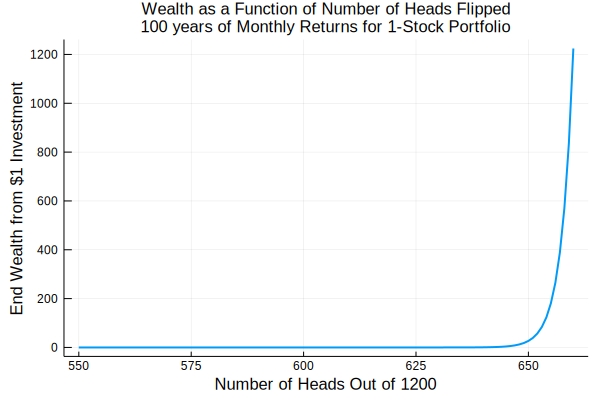

In [44]:
headsplot(0.195, 0.185, 550, 660, 1200)

In [45]:
w1 = cab(coinflip(1, 0.195, 0.185, 0.5), 0, 1000, 1200);
w8 = cab(coinflip(8, 0.195, 0.185, 0.5), 0, 1000, 1200);
w30 = cab(coinflip(30, 0.195, 0.185, 0.5), 0, 1000, 1200);
w1000 = cab(coinflip(1000, 0.195, 0.185, 0.5), 0, 1000, 1200);

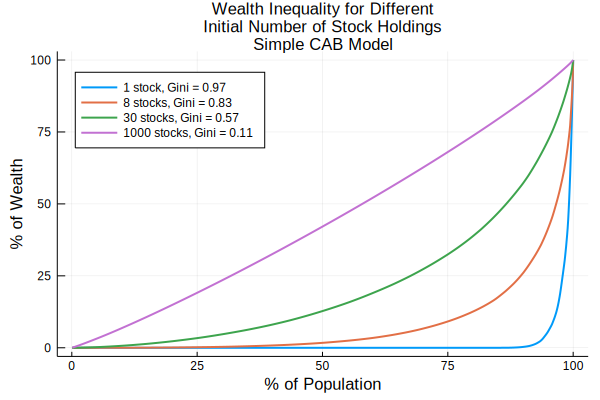

In [47]:
lorenzplot([w1, w8, w30, w1000], [1, 8, 30, 1000])
title!("Wealth Inequality for Different\nInitial Number of Stock Holdings\nSimple CAB Model")

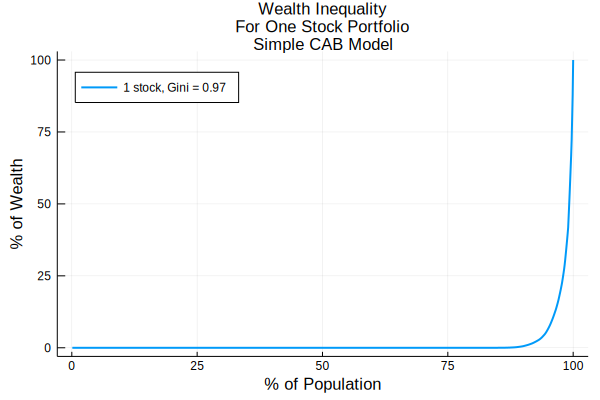

In [41]:
lorenzplot([w1], [1])
title!("Wealth Inequality\nFor One Stock Portfolio\nSimple CAB Model")

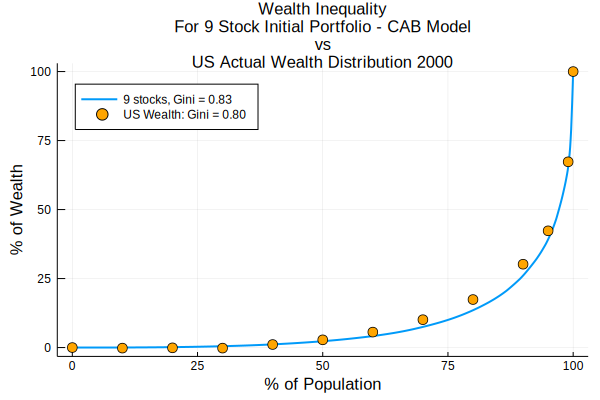

In [38]:
w9 = cab(coinflip(9, 0.195, 0.185, 0.5), 0, 1000, 1200);
lorenzplot([w9],[9])
scatter!(usdata, markersize = 5, c=:orange, labels="US Wealth: Gini = 0.80")
title!("Wealth Inequality\n For 9 Stock Initial Portfolio - CAB Model\nvs\nUS Actual Wealth Distribution 2000")

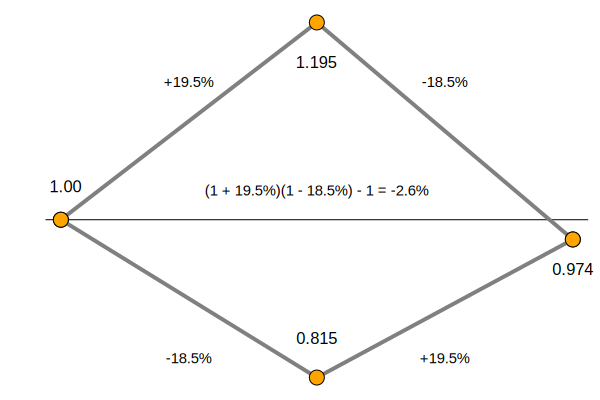

In [16]:
x = [0,1,2]
s2 = [0, 1, -0.1]
s3 = [0, -0.8, -0.1]
plot(x, [s2, s3], legend=false, lw=4, color=[:gray],
     marker=(:circ, 8, :orange), yaxis=false, framestyle=:origin, grid=false, xticks=false)

annotate!([(0.02, 0.17, Plots.text("1.00", 11)),   (1, 0.8,    Plots.text("1.195", 11)),
           (1, -0.6,    Plots.text("0.815", 11)),  (2, 1.8,    Plots.text("1.428", 11)),
           (2, -0.25,   Plots.text("0.974", 11)),  (2, -1.8,   Plots.text("0.664", 11)),
           (0.5, .7,    Plots.text("+19.5%", 10)), (0.5, -.7,  Plots.text("-18.5%", 10)),
           (1.5, 1.7,   Plots.text("+19.5%", 10)), (1.5, 0.7,  Plots.text("-18.5%", 10)),
           (1.5, -0.7,  Plots.text("+19.5%", 10)), (1.5, -1.3, Plots.text("-18.5%", 10)),
           (01, 0.15,   Plots.text("(1 + 19.5%)(1 - 18.5%) - 1 = -2.6%", 10))])

In [17]:
c1 = cab(constant(1, 0.195, 0.185, 0.5), 0, 1000, 1200);
c2 = cab(constant(1, 0.195, 0.185, 0.5), 0, 1000, 1200, c1);
d1 = cab(coinflip(1, 0.195, 0.185, 0.5), 0, 1000, 1200);
d2 = cab(coinflip(1, 0.195, 0.185, 0.5), 0, 1000, 1200, d1);
e1 = cab(coinflip(8, 0.195, 0.185, 0.5), 0, 1000, 1200);
e2 = cab(coinflip(8, 0.195, 0.185, 0.5), 0, 1000, 1200, e1);

In [18]:
mobility(c1,c2,.5,.5)

0.262

In [19]:
mobility(d1,d2,0.5,0.5)

0.214

In [20]:
mobility(e1,e2,0.5,0.5)

0.354